# Preprocess corpus

In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import os
os.chdir('./Corpus')
ps = PorterStemmer()
stopwords_english = set(stopwords.words('english'))

In [2]:
# Load Hong Kong Protest from Chinese newspaper
china_daily = pd.read_csv('China Daily.csv')
people_daily = pd.read_csv('People\'s Daily.csv')
xinhua_agent = pd.read_csv('Xinhua Agent.csv')
# Load Hong Kong Protest from US newspaper
Wall_Street_Journal = pd.read_csv('Wall Street Journal.csv')
Washington_post = pd.read_csv('Washington Post.csv')
New_York_Times = pd.read_csv('New York Times.csv')

In [3]:
# Combine the Chinese newspaper corpus
Chinese_newspaper = pd.concat([china_daily,people_daily,xinhua_agent],axis=0,ignore_index=True)
# Combine the Hong Kong newspaper corpus
US_newspaper = pd.concat([Wall_Street_Journal,New_York_Times,Washington_post],axis=0,ignore_index=True)

In [4]:
# Drop missing value
CN = Chinese_newspaper.dropna().reset_index(drop=True)
US = US_newspaper.dropna()[:-3].reset_index(drop=True)

In [5]:
print(CN.shape)
print(US.shape)

(549, 2)
(549, 2)


# Topic Identification

# LDA (Latent Dirichlet Allocation)

In [6]:
# compile documents
doc_complete_CN = CN['text'].tolist()
doc_complete_US = US['text'].tolist()

In [7]:
from gensim import corpora
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean_CN = [clean(doc).split() for doc in doc_complete_CN] 
doc_clean_US = [clean(doc).split() for doc in doc_complete_US]  

dictionary_CN = corpora.Dictionary(doc_clean_CN)
dictionary_US = corpora.Dictionary(doc_clean_US)


In [8]:
dictionary_CN
dictionary_US

In [9]:
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix_CN = [dictionary_CN.doc2bow(doc) for doc in doc_clean_CN]
doc_term_matrix_US = [dictionary_US.doc2bow(doc) for doc in doc_clean_US]

In [10]:
# print(doc_term_matrix_CN)
# for i in doc_term_matrix_CN:
#     print(i)

In [11]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel_CN = Lda(doc_term_matrix_CN, num_topics=3, id2word = dictionary_CN, passes=50)
ldamodel_US = Lda(doc_term_matrix_US, num_topics=3, id2word = dictionary_US, passes=50)

In [12]:
print(ldamodel_CN.print_topics(num_topics=3, num_words=3))
print(ldamodel_US.print_topics(num_topics=3, num_words=3))

[(0, '0.024*"hong" + 0.019*"kong" + 0.012*"said"'), (1, '0.040*"hong" + 0.035*"kong" + 0.018*"said"'), (2, '0.029*"police" + 0.021*"hong" + 0.020*"kong"')]
[(0, '0.016*"china" + 0.014*"hong" + 0.011*"kong"'), (1, '0.011*"said" + 0.010*"company" + 0.006*"u"'), (2, '0.026*"hong" + 0.020*"kong" + 0.013*"protester"')]


# LSA (Latent Semantic Analysis)

In [250]:
reindexed_data_CN = CN['text']
reindexed_data_US = US['text']
reindexed_data_CN.index = CN.index
reindexed_data_US.index = US.index

In [251]:
display(reindexed_data_CN.head())

0    Policeman hospitalized with leg burns; large g...
1    It's a reflection of Bruce Lee's transcendent ...
2    Experts say it's harder to lure overseas talen...
3    There is a dreary dismal familiarity to me in ...
4    Editor's Note: The US Congress has made the pa...
Name: text, dtype: object

In [252]:
display(reindexed_data_US.head())

0    [Financial Analysis and Commentary]\nPolitical...
1    China appears to be making its long-expected m...
2    [Financial Analysis and Commentary]\nIn his pu...
3    The possibility that Beijing would call in its...
4    Hong Kong -- President Xi Jinping wanted Tuesd...
Name: text, dtype: object

In [280]:
from sklearn.feature_extraction.text import CountVectorizer

small_count_vectorizer = CountVectorizer(stop_words='english', max_features=400)
small_text_sample_CN = reindexed_data_CN.as_matrix()
small_text_sample_US = reindexed_data_US.as_matrix()

#display(small_text_sample_CN)
small_document_term_matrix_CN = small_count_vectorizer.fit_transform(small_text_sample_CN)
small_document_term_matrix_US = small_count_vectorizer.fit_transform(small_text_sample_US)
#display(small_document_term_matrix_CN)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [281]:
from sklearn.decomposition import TruncatedSVD

n_topics = 8

lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix_CN = lsa_model.fit_transform(small_document_term_matrix_CN)
lsa_topic_matrix_US = lsa_model.fit_transform(small_document_term_matrix_US)

# display(lsa_topic_matrix_CN)

In [326]:
from collections import Counter
# Define helper functions
def get_keys(topic_matrix):
    '''returns an integer list of predicted topic categories for a given topic matrix'''
    keys = []
    for i in range(topic_matrix.shape[0]):
        keys.append(topic_matrix[i].argmax())
    return keys

def keys_to_counts(keys):
    '''returns a tuple of topic categories and their accompanying magnitudes for a given list of keys'''
    count_pairs = sorted(Counter(keys).items())
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [327]:
lsa_keys_CN = get_keys(lsa_topic_matrix_CN)
lsa_categories_CN, lsa_counts_CN = keys_to_counts(lsa_keys_CN)

lsa_keys_US = get_keys(lsa_topic_matrix_US)
lsa_categories_US, lsa_counts_US = keys_to_counts(lsa_keys_US)

In [328]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''returns a list of n_topic strings, where each string contains the n most common 
        words in a predicted category, in order'''
    categories, counts = keys_to_counts(keys)
    top_word_indices = []
    for topic in categories:
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))
    return top_words, categories

In [329]:
import numpy as np
top_n_words_lsa_CN, topic_n_CN = get_top_n_words(10, lsa_keys_CN, small_document_term_matrix_CN, small_count_vectorizer)
top_n_words_lsa_US, topic_n_US = get_top_n_words(10, lsa_keys_US, small_document_term_matrix_US, small_count_vectorizer)

for i in range(len(topic_CN)):
    print("Chinese Topic {}: ".format(topic_CN[i]), top_n_words_lsa_CN[i])
for i in range(len(topic_US)):
    print("US Topic {}: ".format(topic_US[i]), top_n_words_lsa_US[i])

Chinese Topic 0:  later important saturday pacific clear online hard war leadership washington
Chinese Topic 1:  pacific popular mrs saturday washington later important taking washpost britain
Chinese Topic 2:  clear close later important mao online day turned won territory
Chinese Topic 7:  america night later important based saturday away power deal known
US Topic 0:  hong kong said china police protesters chinese beijing people protests
US Topic 1:  china chinese said mr trump american trade xi beijing party
US Topic 3:  mr li said trump party president chinese communist power country
US Topic 5:  trump president said trade united states china new world just


Text(0.5,1,'LSA Topic Category Counts - Chinese Newspaper')

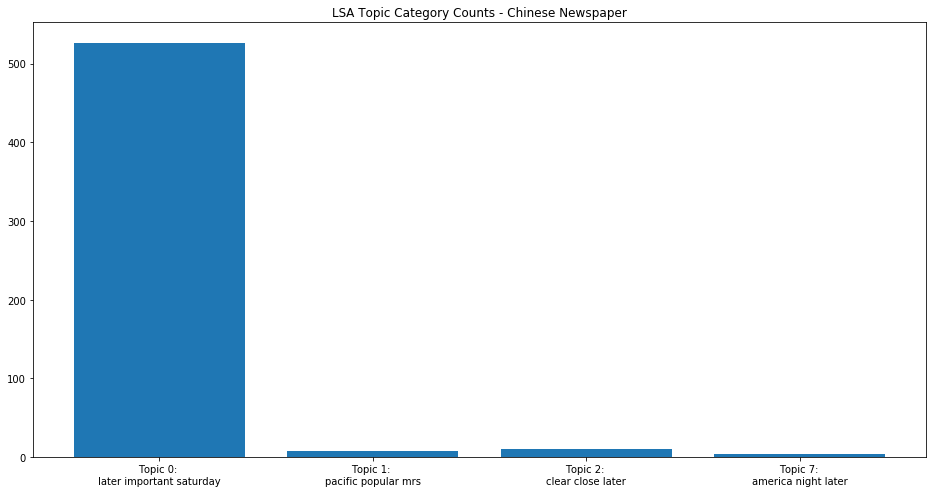

In [344]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

%matplotlib inline
top_3_words_CN, topic_3_CN = get_top_n_words(3, lsa_keys_CN, small_document_term_matrix_CN, small_count_vectorizer)
labels = ['Topic {}: \n'.format(topic_3_CN[i]) + top_3_words_CN[i] for i in range(len(topic_CN))]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(list(i for i in range(len(lsa_categories_CN))), lsa_counts_CN)
ax.set_xticks(list(i for i in range(len(lsa_categories_CN))))
ax.set_xticklabels(labels)
ax.set_title('LSA Topic Category Counts - Chinese Newspaper')

Text(0.5,1,'LSA Topic Category Counts - US Newspaper')

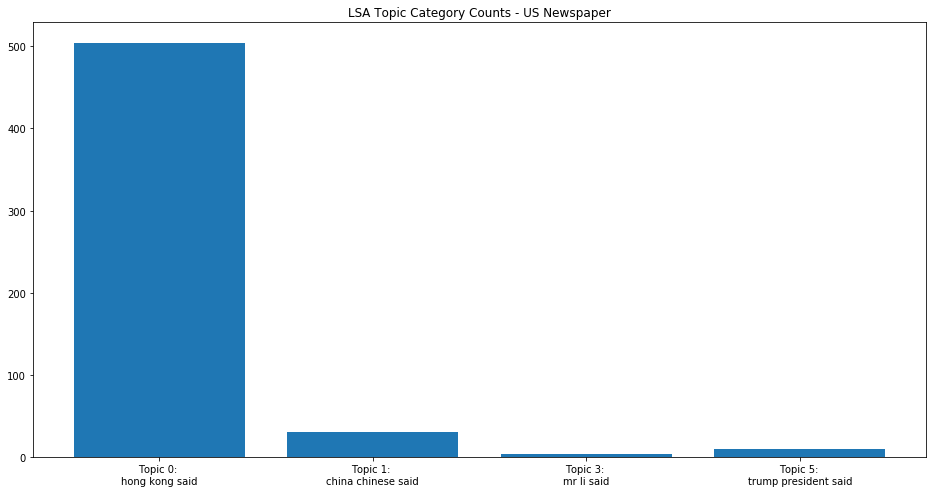

In [342]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

%matplotlib inline
top_3_words_US, topic_3_US = get_top_n_words(3, lsa_keys_US, small_document_term_matrix_US, small_count_vectorizer)
labels = ['Topic {}: \n'.format(topic_3_US[i]) + top_3_words_US[i] for i in range(len(topic_US))]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(list(i for i in range(len(lsa_categories_US))), lsa_counts_US)
ax.set_xticks(list(i for i in range(len(lsa_categories_US))))
ax.set_xticklabels(labels)
ax.set_title('LSA Topic Category Counts - US Newspaper')